# Project Histology Tissue Classification Project - Model validation

## Import needed packages

In [16]:
import os
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import numpy as np
from glob import glob
from skimage.io import imread
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.models import load_model
import pickle

In [17]:
tf.__version__

'1.12.0'

## Data visualization of some examples per classes

### Define plot style

In [30]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [31]:
plt.style.use('seaborn-ticks')

### Looking at some example per classes

In [3]:
df=pd.read_pickle('./data/dataframe_Kather_texture_2016_image_tiles_5000.pkl')

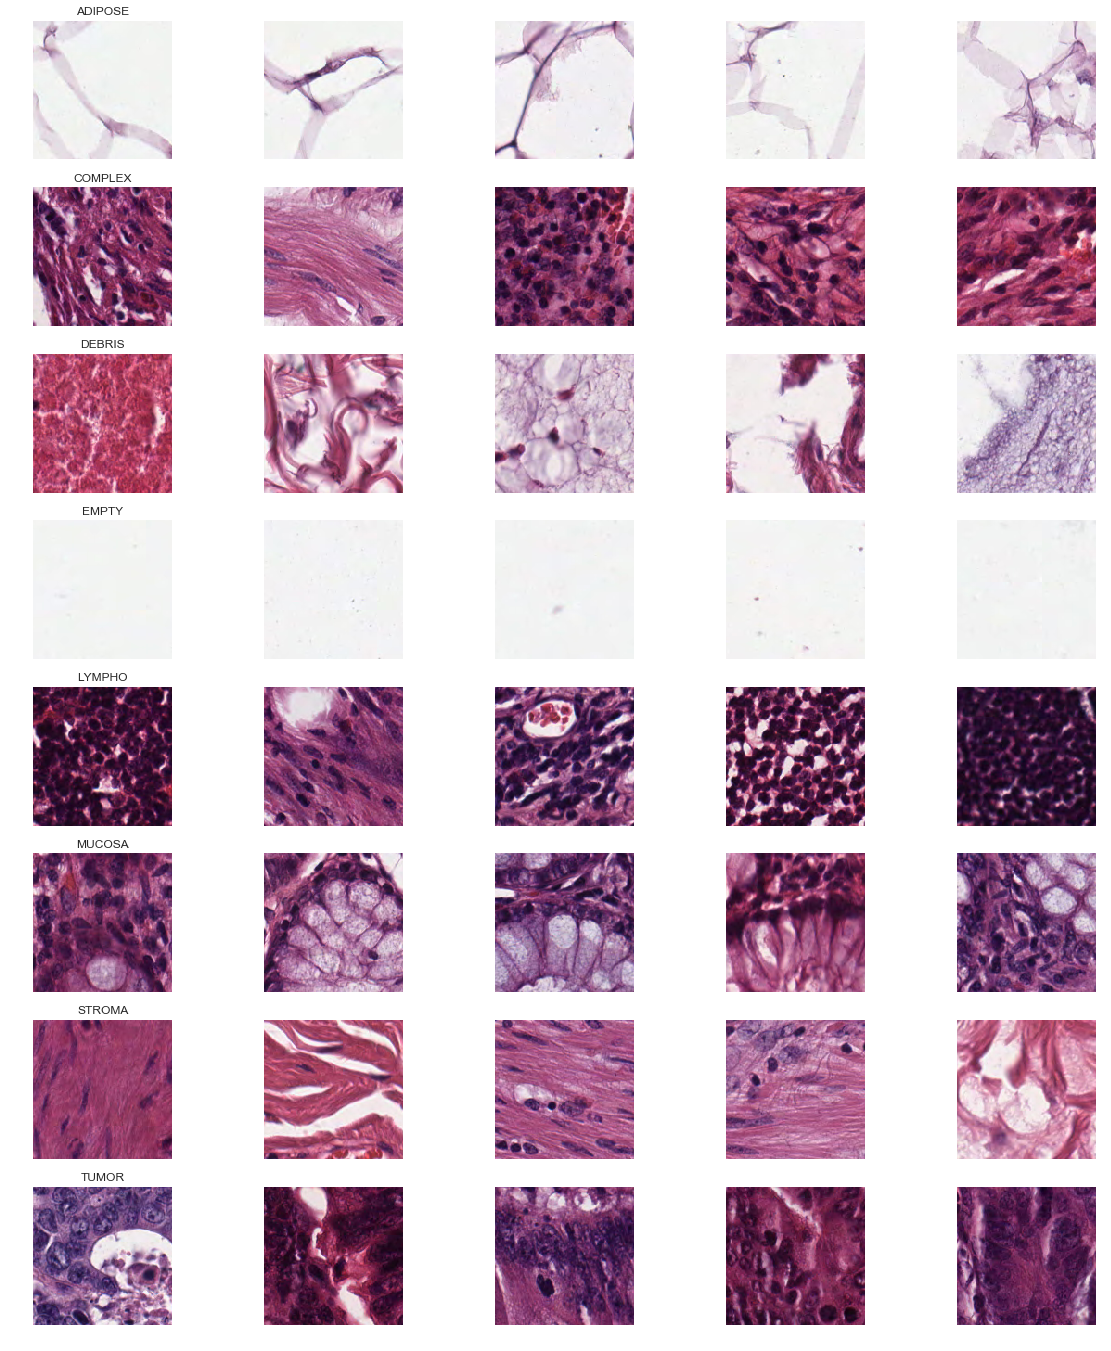

In [32]:
n_samples = 5
fig, m_axs = plt.subplots(8, n_samples, figsize = (4*n_samples, 3*8))

for n_axs, (type_name, type_rows) in zip(m_axs, df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

## Load Model with the best validation accuracy

In [15]:
# best model
best_model='./results/model_vgg16_v4.weights.best.hdf5'

# load the weights with the best validation accuracy
best_model = tf.keras.models.load_model(best_model)

## Check accuracy and loss
### Loading dataset

In [20]:
x_train=pickle.load(open('./data/x_train.pkl', 'rb'))
x_test=pickle.load(open('./data/x_test.pkl', 'rb'))
x_val=pickle.load(open('./data/x_val.pkl', 'rb'))

In [21]:
y_train=pickle.load(open('./data/y_train.pkl', 'rb'))
y_test=pickle.load(open('./data/y_test.pkl', 'rb'))
y_val=pickle.load(open('./data/y_val.pkl', 'rb'))

### Test dataset

In [26]:
# evaluate the model on test set
score = best_model.evaluate(x_test, y_test, verbose=0)

# print test accuracy
print('Loss:')
print('  - loss [testing dataset]: {0:.3f}'.format(score[0]))
print('')
print('Accuracy:')
print('  - accuracy [testing dataset]: {:.2f}%'.format(100*score[1]))

Loss:
  - loss [testing dataset]: 0.362

Accuracy:
  - accuracy [testing dataset]: 88.80%


### Training dataset

In [27]:
# evaluate the model on training set
score = best_model.evaluate(x_train, y_train, verbose=0)

# print test accuracy
print('Loss:')
print('  - loss [training dataset]: {0:.3f}'.format(score[0]))
print('')
print('Accuracy:')
print('  - accuracy [training dataset]: {:.2f}%'.format(100*score[1]))

Loss:
  - loss [training dataset]: 0.123

Accuracy:
  - accuracy [training dataset]: 96.23%


### Validation dataset

In [28]:
# evaluate the model on training set
score = best_model.evaluate(x_val, y_val, verbose=0)

# print test accuracy
print('Loss:')
print('  - loss [validation dataset]: {0:.3f}'.format(score[0]))
print('')
print('Accuracy:')
print('  - accuracy [validation dataset]: {:.2f}%'.format(100*score[1]))

Loss:
  - loss [validation dataset]: 0.336

Accuracy:
  - accuracy [validation dataset]: 89.30%


## Visualize predictions

In [33]:
y_hat = best_model.predict(x_test)

In [35]:
dict_label=['ADIPOSE',
            'COMPLEX',
            'DEBRIS',
            'EMPTY',
            'LYMPHO',
            'MUCOSA',
            'STROMA',
            'TUMOR']

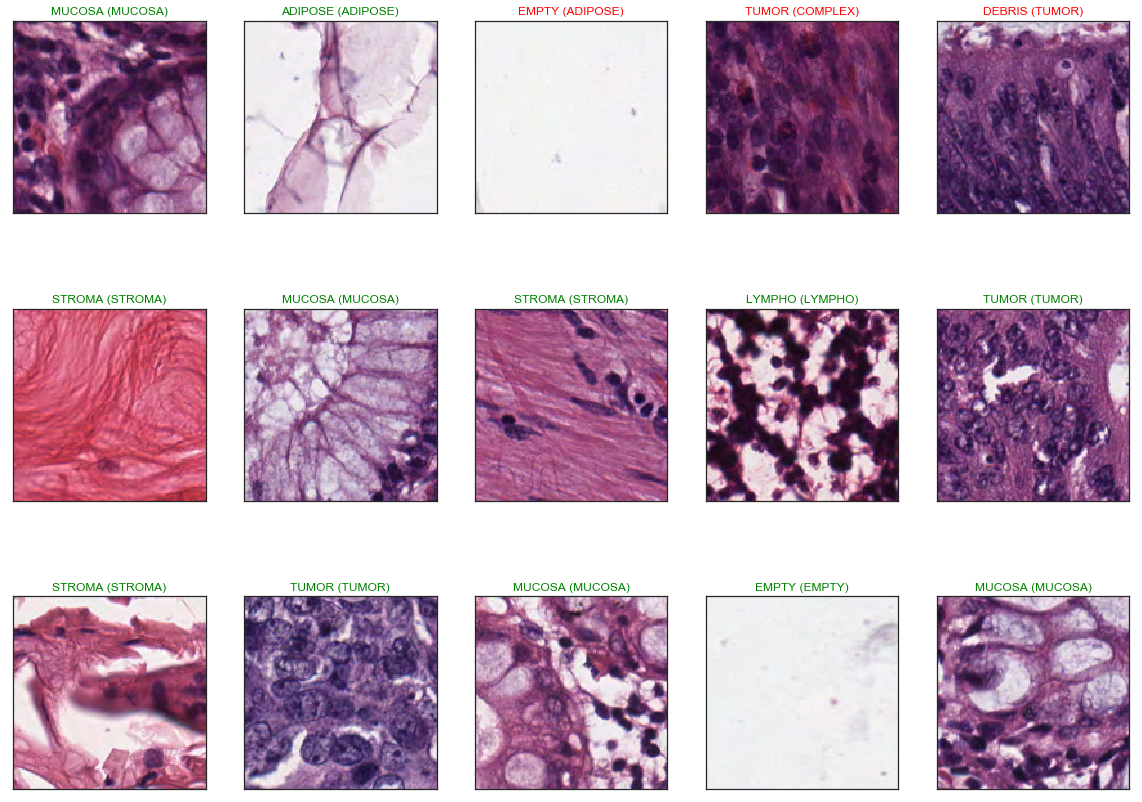

In [42]:
# plot a random sample of 10 test images, their predicted labels and ground truth
figure = plt.figure(figsize=(20, 15))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]))
    predict_index = np.argmax(y_hat[index])
    true_index = np.argmax(y_test[index])
    # Set the title for each image
    ax.set_title("{} ({})".format(dict_label[predict_index], 
                                  dict_label[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

## Confusion matrix
### Helper functions

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label');
    plt.xlabel('Predicted label');

### Simple confusion matrix

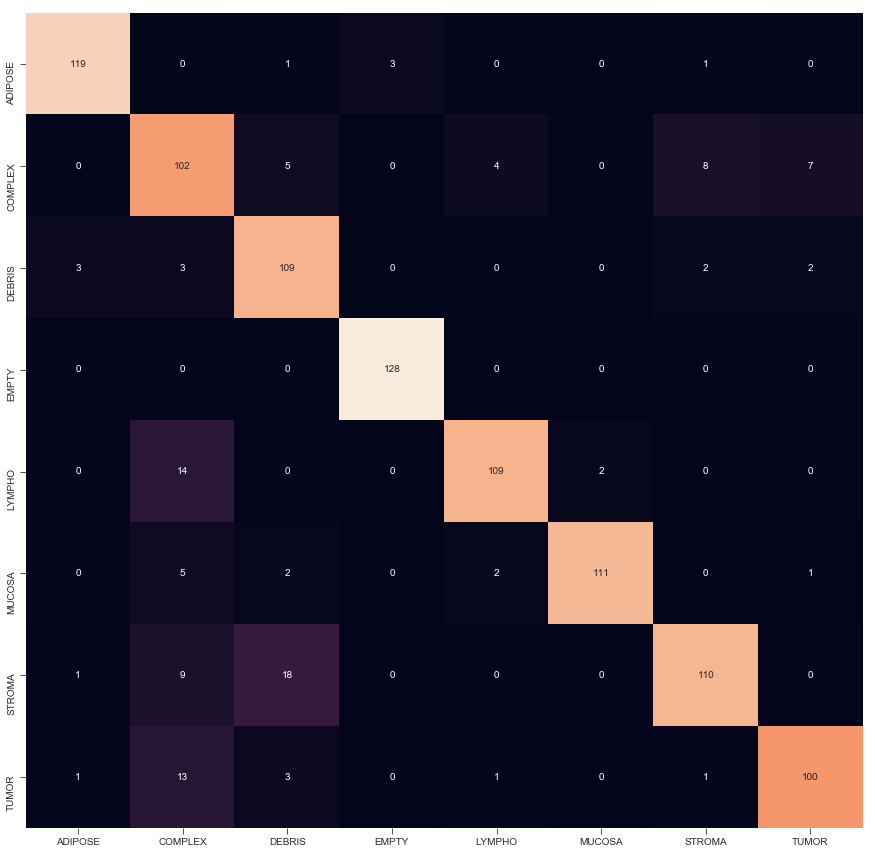

In [48]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(1, 1, 1)
predict_index = np.argmax(y_hat, axis = 1)
true_index = np.argmax(y_test, axis = 1)
sns.heatmap(confusion_matrix(true_index, predict_index), 
            annot=True, cbar=False, fmt='d', ax=ax)
ax.set_yticklabels(dict_label, minor=False)
ax.set_xticklabels(dict_label, minor=False);

### Confusion matrix with more informations

In [53]:
# compute confusion matrix
cnf_matrix = confusion_matrix(true_index, predict_index)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[119   0   1   3   0   0   1   0]
 [  0 102   5   0   4   0   8   7]
 [  3   3 109   0   0   0   2   2]
 [  0   0   0 128   0   0   0   0]
 [  0  14   0   0 109   2   0   0]
 [  0   5   2   0   2 111   0   1]
 [  1   9  18   0   0   0 110   0]
 [  1  13   3   0   1   0   1 100]]


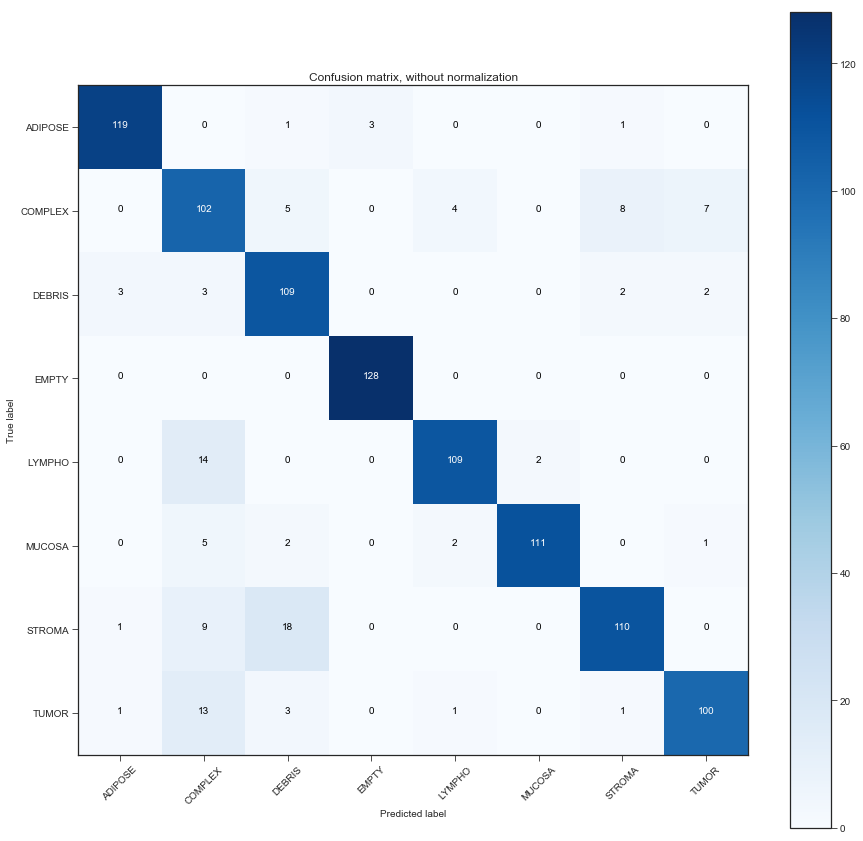

In [54]:
# plot non-normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=dict_label,
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.96 0.   0.01 0.02 0.   0.   0.01 0.  ]
 [0.   0.81 0.04 0.   0.03 0.   0.06 0.06]
 [0.03 0.03 0.92 0.   0.   0.   0.02 0.02]
 [0.   0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.11 0.   0.   0.87 0.02 0.   0.  ]
 [0.   0.04 0.02 0.   0.02 0.92 0.   0.01]
 [0.01 0.07 0.13 0.   0.   0.   0.8  0.  ]
 [0.01 0.11 0.03 0.   0.01 0.   0.01 0.84]]


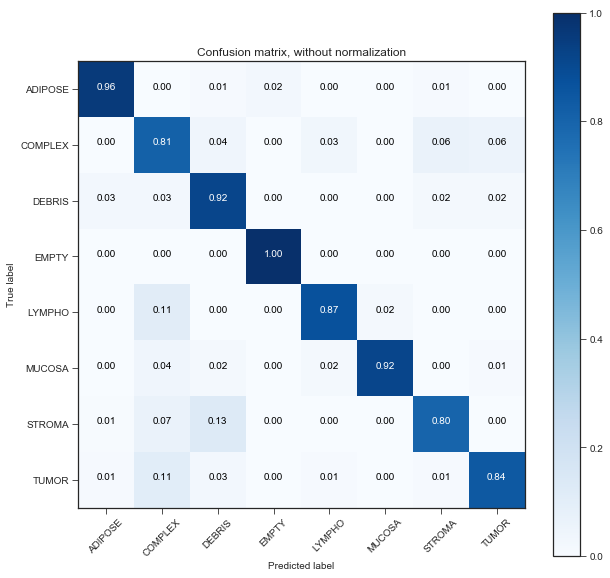

In [51]:
# plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=dict_label,normalize=True,
                      title='Confusion matrix, without normalization')